In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
import pandas as pd
df = pd.read_csv("/content/UNBER-1k.csv")
df

,reel_id,UnsafeType,Visual texts
0,www.facebook.com/reel/1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie
1,www.facebook.com/reel/1006146964533997,Safe,NaN
2,www.facebook.com/reel/1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love
3,www.facebook.com/reel/1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop
4,www.facebook.com/reel/1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং
...,...,...,...
1112,www.facebook.com/reel/946250977507282,Suicidal,কিছু কথা বাকি ছিল আর হয়তো কোনদিনও বলা হবে না
1113,www.facebook.com/reel/951238780033589,Suicidal,তোমাকে মন দিয়ে ভালোবাসতাম উপহার হিসাবে তোমার ক...
1114,www.facebook.com/reel/974520454682213,Suicidal,ওগো শুনছো একথা বলা মানুষটা আজ অন্য কারোর।
1115,www.facebook.com/reel/975204184253727,Suicidal,"মন দিয়ে ভালোবাসতে গেলাম, অবশেষে ধোকা পেলাম।"


In [4]:
df['UnsafeType'], uniques = pd.factorize(df['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [5]:
dir = "/content/drive/MyDrive/UNBER-1k/Extracted_Features"

In [6]:
X = []
y = []

In [7]:
reels = []

for file in os.listdir(dir):
    if file.endswith(".npy"):
        file_path = os.path.join(dir, file)
        features = np.load(file_path)
        file_path = file_path.replace(".npy", "")
        file_path = file_path.replace(".wav", "")
        file_path = file_path.replace("/content/drive/MyDrive/UNBER-1k/Extracted_Features/audio", "www.facebook.com/reel/")
        if file_path in df['reel_id'].values:
          index = df.index[df['reel_id'] == file_path].tolist()[0]
          unsafe_type = df.loc[index, 'UnsafeType']
          y.append(unsafe_type)
          X.append(features)

In [8]:
X = np.array(X, dtype=np.float32)

In [9]:
X.shape

(1111, 21160)

In [10]:
y = np.array(y)
y.shape

(1111,)

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
X = np.expand_dims(X, axis=-1)

In [13]:
X.shape

(1111, 21160, 1)

In [14]:
import numpy as np

combined = list(zip(X, y))

np.random.shuffle(combined)

X, y = zip(*combined)

X = np.array(X)
y = np.array(y)

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

In [16]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(4, activation='softmax')  # 4-class output
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [19]:
model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.3639 - loss: 2.0972 - val_accuracy: 0.4045 - val_loss: 1.3360 - learning_rate: 1.0000e-05
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.4673 - loss: 1.5168 - val_accuracy: 0.3989 - val_loss: 1.4144 - learning_rate: 1.0000e-05
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.5697 - loss: 1.2485 - val_accuracy: 0.3989 - val_loss: 1.5190 - learning_rate: 1.0000e-05
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6316 - loss: 0.9495
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.6319 - loss: 0.9497 - val_accuracy: 0.3820 - val_loss: 1.6652 - learning_rate: 1.0000e-05
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7120 - loss: 0.8389 - val_accuracy: 0.3989 - val_loss: 1.7336 - learning_rate: 5.0000e-06
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.78

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4169 - loss: 1.3173
Test Accuracy: 0.4222


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step


In [23]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.43      0.83      0.57        18
           1       0.33      0.15      0.21        13
           2       0.67      0.22      0.33         9
           3       0.00      0.00      0.00         5

    accuracy                           0.42        45
   macro avg       0.36      0.30      0.28        45
weighted avg       0.40      0.42      0.35        45



In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

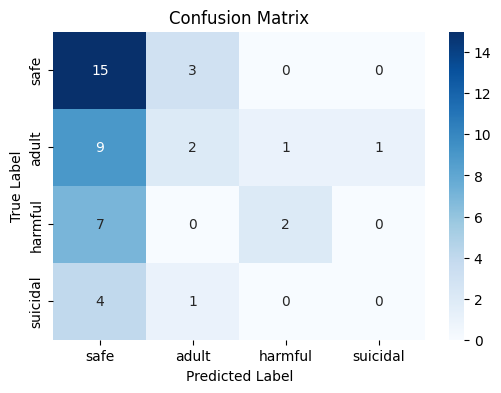

In [25]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["safe","adult","harmful","suicidal"], yticklabels=["safe","adult","harmful","suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [27]:
model.save('/content/drive/MyDrive/UNBER-1k/Models/cnn_model.keras')